# Stima Rt e previsioni

Rt italiano e regionale e previsione incidenza.

> Max Pierini, Sandra Mazzoli, Alessio Pamovio

***

Il modello di previsione dei nuovi casi può fallire nei seguenti casi:

- _Eventi o interventi atti a diminuire drasticamente il tasso di trasmissione_ (lockdown, zone rosse, rinforzo delle norme di igiene e sicurezza, ecc). In questo caso $R_t$ osservato, e di conseguenza il numero di nuovi casi, potrebbero risultare inferiori al miglior scenario previsto.
- _Eventi o situazioni in grado di aumentare drasticamente il tasso di trasmissione_ (grandi assembramenti, netta riduzione della conformità alle norme di igiene e sicurezza, riapertura scuole e università, ecc). In questo caso $R_t$ osservato, e di conseguenza il numero di nuovi casi, potrebbero risultare superiori al peggior scenario previsto.
- _Interventi atti ad aumentare il numero di test (tamponi) effettuati sulla popolazione_. In questo caso il Tasso di Posività osservato potrebbe risultare inferiore al miglior scenario previsto.
- _Decisioni atte a diminuire il numero di test (tamponi) effettuati sulla popolazione_. In questo caso il Tasso di Posività osservato potrebbe risultare superiore al peggior scenario previsto.

In ogni caso, l'osservazione di un numero di nuovi casi e/o di un Tasso di Positività

- **inferiori al miglior scenario previsto** è una buona indicazione della resa degli interventi di contenimento eventualmente attuati
- **superiori al peggior scenario previsto** è una buona indicazione del fallimento degli interventi di contenimento eventualmente attuati e/o una chiara indicazione a considerare un rinforzo degli interventi in atto o l'introduzione di interventi più efficaci

> NB: gli $R_t$ stimati da EpiDataItalia sono parametrizzati attualmente sui <u>soli nuovi casi</u> riportati al [Dipartimento di Protezione Civile](https://github.com/pcm-dpc/COVID-19) e **non sono sovrapponibili al numero di riproduzione stimato da ISS-EpiCentro** che utilizza lo stesso modello *EpiEstim* ([A new framework and software to estimate time-varying reproduction numbers during epidemics, Cori-Ferguson-Fraser 2013](https://doi.org/10.1093/aje/kwt133)) ma con dati aggiuntivi attualmente **non disponibili al pubblico** (il numero di casi sintomatici con data di inizio sintomi, il numero di casi sintomatici importati da un’altra regione o dall’estero). Per info sul modello in uso da ISS-EpiCentro consultare la pagina [FAQ sul calcolo del Rt](https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt) di ISS. Per chiedere al Governo l'accesso pubblico a tutti i dati grezzi disaggregati di COVID-19 in Italia consigliamo l'adesione alla **[Petizione DatiBeneComune](https://datibenecomune.it)**.

***

Modelli utilizzati:

- stima di Rt: EpiEstim Cori et al. (ref: [Package ‘EpiEstim’](https://cran.r-project.org/web/packages/EpiEstim/EpiEstim.pdf), [Cori et al. 2013](https://academic.oup.com/aje/article/178/9/1505/89262))
    - implementato con Markov chain Monte Carlo in `JAGS` e corretto per ignorare incidenze inferiori a una soglia stabilita nella finestra temporale scelta. Finestra 14 giorni, soglia minima 50 nuovi casi
- previsioni: Bettencourt-Ribeiro (ref: [Bettencourt & Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185#s5))
    - implementato con Markov chain Monte Carlo in `JAGS`. Scenari con Rt stabile e incremento/decremento del 33% su finestra temporale scelta di 14 giorni
- Distribuzione di intervallo di generazione Cereda-Tirani et al. (ref: [Cereda-Tirani 2020](arXiv:2003.09320))

# Metodo

Il metodo **EpiEstim** ([Cori et al. 2013](https://academic.oup.com/aje/article/178/9/1505/89262)) si basa sulla semplice assunzione che

$$
R_t \sim \Gamma \left( 
A = \sum_{i=0}^{\Delta} I_{t-\Delta} \;,\; 
B = \sum_{i=0}^{\Delta} \gamma_{i} I_{t-\Delta} \right)
$$

dove $I$ è l'incidenza, la distribuzione Gamma è parametrizzata su shape $A$ e rate $B$, $\Delta$ è un'intervallo temporale scelto (solitamente tra 7 e 14 giorni) e $\gamma_{i}$ è la massa di probabilità l'intervallo seriale $\gamma$ discretizzato

$$
\gamma \sim \Gamma( \alpha , \beta )
$$

in cui $\alpha$ e $\beta$ sono shape e rate. Il parametro $A$ è la somma delle incidenze del periodo $\Delta$, mentre $B$ è definita da Cori come $overall infectivity$ (infettività complessiva). Il concetto, semplificando, è che i nuovi casi $A$ ossevati nell'intervallo $\Delta$ sono stati verosimilmente contagiati da infetti nel medesimo intervallo che si possono stimare come i casi osservati $A$ ponderati sulla massa di probabilità (PMF) dell'intervello seriale discretizzato.

Dalle proprietà della distribuzione Gamma si evince pertanto che la media di $R_t$ è

$$
\hat{R_t} = \frac{A}{B}
$$

e la deviazione standard è

$$
\sigma(R_t) = \frac{\sqrt{A}}{B}
$$

dalla PDF della distribuzione Gamma, è possibile calcolare anche l'intervallo di credibilità (qui 99%) che, in statistica bayesiana, ha la medesima funzione dell'intervallo di confidenza frequentista.

Dunque il rapporto tra $A$ e $B$ definisce la media di $R_t$. In questo modo l'osservazione di un'incidenza $A$ pari a 100 nuovi casi su un'infettività complessiva di 50 infetti, darà come risultato una media di $R_t$ pari a 2. Allo stesso modo se $A=1,000$ e $B=500$, o se $A=10,000$ e $B=5,000$ e in generale se $A=2B$. Ma grazie alle proprietà della distribuzione Gamma, più aumentano $A$ e $B$ più si riduce l'intervallo di credibilità e siamo quindi man mano "più sicuri" che il valore reale di $R_t$ sia vicino alla media stimata.

In [1]:
import datetime as dt
import json
import numpy as np
import pandas as pd
import scipy.stats as sps
import pyjags
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown
sns.set()

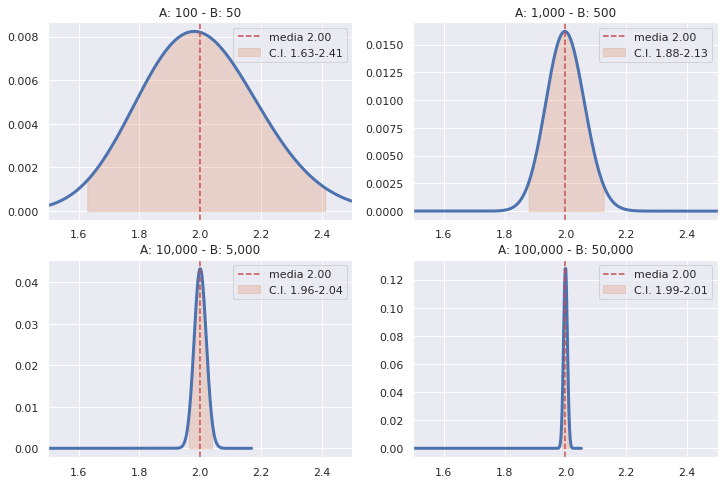

In [2]:
# quantiles for confidence window
CI = .95
q1 = (1 - CI) / 2
q2 = 1 - q1

A = 100
B = 50

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, ax in enumerate(axs.flat):
    
    _a = 10 * 10 ** (i+1)
    _b = 10 * 10 ** (i+1) / 2
    ex1_dist = sps.gamma(a=_a, scale=1/_b)
    ex1_x = np.linspace(0, ex1_dist.ppf(1-1e-16), 1000)
    ex1_y = ex1_dist.pdf(ex1_x)
    ex1_y /= ex1_y.sum()
    ex1_mu = A / B
    ex1_lo = ex1_dist.ppf(q1)
    ex1_hi = ex1_dist.ppf(q2)
    ax.plot(ex1_x, ex1_y, lw=3)
    ax.fill_between(
        ex1_x[(ex1_x>=ex1_lo) & (ex1_x<=ex1_hi)],
        0, ex1_y[(ex1_x>=ex1_lo) & (ex1_x<=ex1_hi)],
        alpha=.25, color='C1',
        label=f"C.I. {ex1_lo:.2f}-{ex1_hi:.2f}"
    )
    ax.axvline(ex1_mu, color='r', ls='--', label=f'media {ex1_mu:.2f}')
    ax.set(
        xlim=(1.5, 2.5),
        title=f"A: {_a:,.0f} - B: {_b:,.0f}"
    )
    ax.legend(loc='upper right')
plt.show()

Per questo motivo, scegliamo in questa implementazione di ignorare somme di incidenze $A$ inferiori a 50 casi nel $\Delta$ definito di 14 giorni, che porterebbero ad un intervallo di credibilità eccessivamente ampio.

In questa sezione, per l'Italia, il metodo è implementato con Markov chain Monte Carlo in `JAGS` al fine di stimare una previsione dell'incidenza dato l'ultimo $R_t$ e la media dell'incidenza osservata nell'ultima settima $\hat{I_t}$ con approssimazione del metodo Bettencourt-Ribeiro ([Bettencourt & Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185#s5)), secondo cui l'incidenza prevista dopo $\tau$ giorni è

$$
I_{t+\tau} = \hat{I_t} \cdot \exp \left( \frac{\tau}{\hat{\gamma}} (R_t - 1) \right)
$$

in cui $\hat{\gamma}$ è la media dell'intervallo seriale $\gamma$.

Nella presente trattazione, i priors di $\hat{I_t}$ sono distribuiti gaussiani positivi con deviazione standard 100

$$
\hat{I_t} \sim \mathcal{N}^+( \mu = \hat{I_t} \;,\; \sigma = 100 )
$$

e i posteriors $I_{t+\tau}$ sono distribuiti Poisson

$$
I_{t+\tau} \sim \mathcal{P}( \lambda = I_{t+\tau} )
$$

Per le regioni e nelle altre sezioni, il metodo è implementato in `python`, tratto dall'implementazione in `R` del pacchetto EpiEstim ([Package ‘EpiEstim’](https://cran.r-project.org/web/packages/EpiEstim/EpiEstim.pdf)).

***

In [3]:
adapt = 100
warmup = 500
sample = 500

In [4]:
start = dt.datetime.now()

In [5]:
ISS_sh = 1.87
ISS_ra = 0.28

In [6]:
def gamma_mu_sd_from_shape_rate(shape, rate):
    mu = shape / rate
    sd = np.sqrt(shape) / rate
    return mu, sd

In [7]:
def generation_time_gamma(sh, ra, plot=True, title='Estimated'):

    dist = sps.gamma(a=sh, scale=1/ra)

    max_x = int(np.ceil(dist.ppf(.9999)))
    x = np.linspace(0, max_x, max_x+1)
    y = dist.pdf(x)
    y /= y.sum()
    
    mu, sd = gamma_mu_sd_from_shape_rate(sh, ra)
    
    if plot:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.bar(x, y, alpha=.5)
        ax.plot(x, y)
        ax.axvline(mu, color='r', ls='--', label=f'mean {mu:.1f} days')
        ax.legend()
        ax.set(
            title=f'{title} COVID-19 Generation Interval '+\
                  f'shape={sh:.3f}, rate={ra:.3f}',
            xlabel='days',
            ylabel='probability density'
        )
        plt.show()

    return x, y, mu, sd

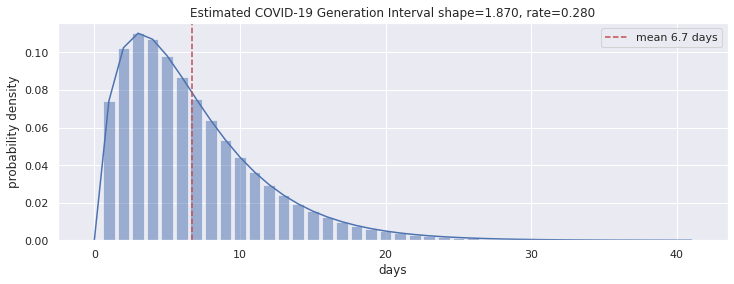

In [8]:
SI_x, SI_y, SI_mu, SI_sd = generation_time_gamma(ISS_sh, ISS_ra)

In [9]:
it = pd.read_csv(
    "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv",
     usecols=['data', 'nuovi_positivi', 'totale_casi'],
     parse_dates=['data'],
     index_col=['data'],
     squeeze=True).sort_index()
it.index = it.index.normalize()

In [10]:
window = 14

In [11]:
modelString = """
model {
    mu_prior <- 5
    sd_prior <- 5
    
    a_prior <- (mu_prior / sd_prior)^2    # shape
    b_prior <- (sd_prior^2) / mu_prior    # scale
    
    for ( t in 1:T ) {
        i_start[t] <- T - t + 1
        lambda[t] <- sum( SI_pmf[1:t] * incidence_rev[i_start[t]:T] )
    }
    
    for ( t in 1:D ) {
        incidence_sum[t] <- sum( incidence[t_start[t]:t_end[t]] )
        a_posterior[t] <- ifelse( t_end[t] > final_mean_si , a_prior + incidence_sum[t] , 0.1 )
        
        lambda_sum[t] <- sum( lambda[t_start[t]:t_end[t]] )
        b_posterior[t] <- ifelse( t_end[t] > final_mean_si , 1 / b_prior + lambda_sum[t] , 1 )
        
        confidence[t] ~ dgamma( a_posterior[t] , b_posterior[t] )
        no_results[t] ~ dgamma( 0.1 , 1 )
        
        R[t] <- ifelse( incidence_sum[t] > ignore_below , confidence[t] , no_results[t] )
    }
    
    R_pred_ml <- R[D]
    R_pred_hi[1] <- R[D]
    R_pred_lo[1] <- R[D]
    
    pred_incidence_ml[1] ~ dpois( sum( incidence[(T-6):T] ) / 7 )
    pred_incidence_lo[1] ~ dpois( sum( incidence[(T-6):T] ) / 7 )
    pred_incidence_hi[1] ~ dpois( sum( incidence[(T-6):T] ) / 7 )
    
    for ( p in 2:P ) {

        R_pred_hi[p] <- R_pred_ml + 0.33 * (p-1) / (P-1)
        R_pred_lo[p] <- R_pred_ml - 0.33 * (p-1) / (P-1)

        # most likely scenario
        y_prior_ml[p] ~ dnorm( pred_incidence_ml[p-1] , 1 / (pred_incidence_ml[p-1] / 100)^2 )  T(0,)
        lambda_pred_ml[p] <- y_prior_ml[p] * exp( 1 / gamma * ( R_pred_ml - 1 ) )
        pred_incidence_ml[p] ~ dpois( lambda_pred_ml[p] )
        
        # worst scenario
        y_prior_hi[p] ~ dnorm( pred_incidence_hi[p-1] , 1 / (pred_incidence_hi[p-1] / 100)^2 )  T(0,)
        lambda_pred_hi[p] <- y_prior_hi[p] * exp( 1 / gamma * ( R_pred_hi[p-1] - 1 ) )
        pred_incidence_hi[p] ~ dpois( lambda_pred_hi[p] )
        
        # best scenario
        y_prior_lo[p] ~ dnorm( pred_incidence_lo[p-1] , 1 / (pred_incidence_lo[p-1] / 100)^2 )  T(0,)
        lambda_pred_lo[p] <- y_prior_lo[p] * exp( 1 / gamma * ( R_pred_lo[p-1] - 1 ) )
        pred_incidence_lo[p] ~ dpois( lambda_pred_lo[p] )
    }
}
"""

In [12]:
def epi_estim_mcmc(model_data):

    jags_model = pyjags.Model(
        code=modelString, 
        data=model_data,
        chains=4, 
        adapt=adapt,
        progress_bar=False
    )

    jags_posteriors = jags_model.sample(
        warmup + sample, vars=['R', 
                               'pred_incidence_ml',
                               'pred_incidence_hi',
                               'pred_incidence_lo',
                              ]
    )
    return jags_posteriors

In [13]:
def plot_Rt(pyjags_data,
            dates, date_min,
            SI_mu, SI_sd,
            window,
            title='Italy'):

    summary = az.summary(pyjags_data, var_names="R", hdi_prob=.99, kind="stats")

    summary.index = dates  # obs_df.index[window+1:]

    ax = summary.plot(
        y='mean', color='w', alpha=.25, lw=1, figsize=(15, 5), ylim=(0, 5),
        label='Rt'
    )

    ax.fill_between(
        summary.index, 
        np.where(summary['hdi_99.5%']<1, summary['hdi_99.5%'], 1), 
        np.where(summary['hdi_0.5%']<1, summary['hdi_0.5%'], 1), 
        alpha=1, color='C2', label='lower than 1')

    ax.fill_between(
        summary.index, 
        np.where(summary['hdi_99.5%']>1, summary['hdi_99.5%'], 1), 
        np.where(summary['hdi_0.5%']>1, summary['hdi_0.5%'], 1), 
        alpha=1, color='C3', label='higher than 1')

    ax.set(
        title=f'{title} COVID-19: Rt estimation (EpiEstim MCMC method, window {window} days, '+\
              f'SI  $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$ days) '+\
              f'C.I. 99%',
        ylim=(0, 4),
        xlim=(date_min, dates[-1]),
        ylabel='Rt'
    )
    ax.tick_params(axis='y', which='both', labelleft='on', labelright='on')
    ax.legend(loc='upper right')

    ax.axhline(1, color='k', ls='-')
    plt.show()
    
    return summary

In [14]:
def plot_predictions(pyjags_data, 
                     SI_mu, 
                     date_0,
                     obs_df,
                     region='Italy'):

    summary = az.summary(pyjags_data, var_names="pred_incidence", filter_vars='regex', kind="stats")

    fig, ax = plt.subplots(2, 1, figsize=(15, 9))

    for scenario, which in zip(['ml', 'hi', 'lo'], ['likely', 'worst', 'best']):

        sc = summary[summary.index.str.contains(scenario)].copy(deep=True)
        sc.index = pd.date_range(
            date_0, date_0 + pd.Timedelta(days=sc.index.size-1)
        )
        lo = sc['hdi_3%']
        hi = sc['hdi_97%']
        for axis in ax:
            sc.plot(ax=axis, y='mean', label=f'{which} scenario')
            axis.fill_between(
                sc.index,
                lo, hi, alpha=.2
            )

    obs_df.plot(ax=ax[0], marker='.', lw=1, color='k', label='observed')
    obs_df.iloc[-15:].plot(ax=ax[1], marker='o', color='k', label='observed')

    for axis in ax:
        axis.plot(
            [obs_df.index[-7], obs_df.index[-1]],
            [obs_df.iloc[-7:].mean(), obs_df.iloc[-7:].mean()],
            color='b', label='7 days mean'
        )
    
        ylim = axis.get_ylim()
        axis.tick_params(axis='y', which='both', labelleft='on', labelright='on')
        axis.set(
            ylim=(0, ylim[-1]),
            title=f'{region} COVID-19: incidence prediction (Bettencourt-Ribeiro method, '+\
                  f'$\gamma^{{-1}}={SI_mu:.1f}$ days) scenarios $R_t\pm0.33$',
            ylabel='new positive',
            xlabel=None,
        )
    plt.show()

# ITALY

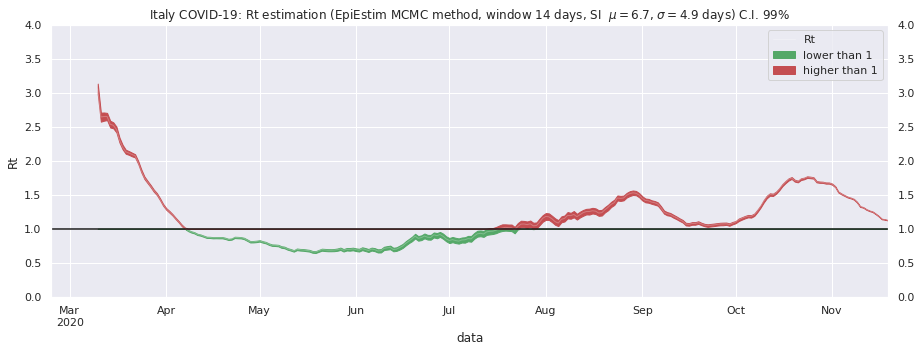

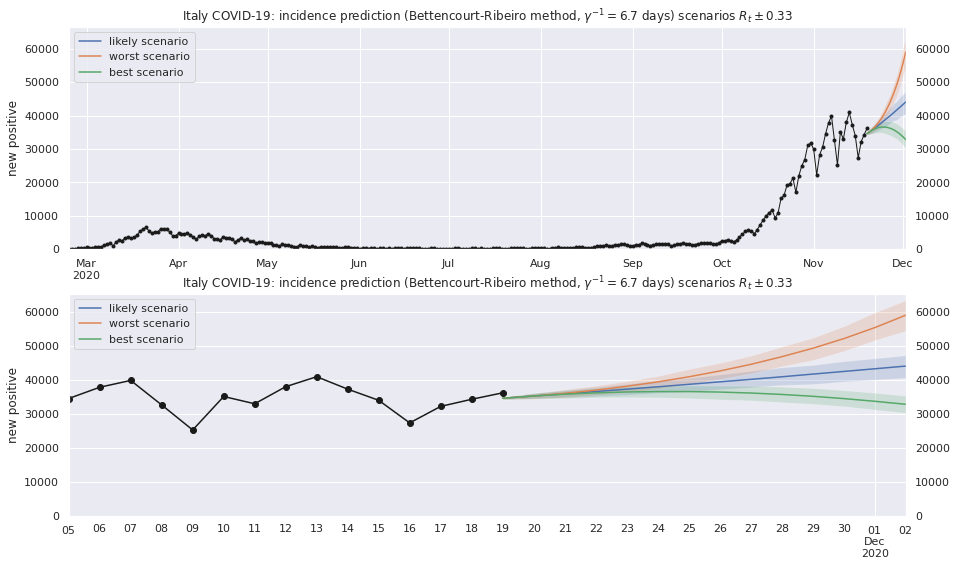

In [15]:
incidence = it.nuovi_positivi.values

# length of all observations
T = incidence.size
SI_tot = np.concatenate((SI_y, np.zeros(T - SI_y.size)))
final_mean_si = np.sum(
    SI_tot * np.arange(0, SI_tot.size, 1)
)

# start and end of posteriors
t_start = np.arange(1, T - window, 1)
t_end = t_start + window

model_data = {
    'T': T,
    'D': t_start.size,
    'incidence': it.nuovi_positivi.values,
    'incidence_rev': it.nuovi_positivi.values[::-1],
    't_start': t_start,
    't_end': t_end,
    'SI_pmf': SI_tot,
    'final_mean_si': final_mean_si,
    'P': window,
    'gamma': final_mean_si,
    'ignore_below': 50
}
post = epi_estim_mcmc(model_data)

pyjags_data = az.from_pyjags(post, warmup_iterations=warmup, save_warmup=False)

smry = plot_Rt(pyjags_data,
            it.index[window+1:],
            it.index[0],
            SI_mu, SI_sd,
            window,
            title='Italy')

plot_predictions(pyjags_data, 
                     SI_mu, 
                     it.index[-1],
                     it.nuovi_positivi,
                     region='Italy')

In [16]:
Rt_italy_json = {
    'mean': smry['mean'].iloc[-1],
    'max': smry['hdi_99.5%'].iloc[-1],
    'min': smry['hdi_0.5%'].iloc[-1]
}
with open('Rt_italy.json', 'w') as f:
    json.dump(Rt_italy_json, f)

# REGIONS

In [17]:
def overall_infectivity(incid, SI_y):
    T = incid.size
    _lambda = np.zeros(T)
    _lambda[0] = np.nan
    for t in range(T):
        if not t:
            continue
        _lambda[t] = np.sum(
            SI_y[:t+1] * 
            incid[:t+1][::-1]
        )
    return _lambda

def posterior_from_si_distr(incid, SI_y, a_prior, b_prior, t_start, t_end):
    nb_time_periods = t_start.size
    _lambda = overall_infectivity(incid, SI_y)
    final_mean_si = np.sum(
        SI_y * np.arange(0, SI_y.size, 1)
    )
    a_posterior = np.zeros(shape=nb_time_periods)
    b_posterior = np.zeros(shape=nb_time_periods)
    for t in range(nb_time_periods):
        incid_sum = np.sum(incid[t_start[t]:t_end[t]+1])
        lambda_sum = np.sum(_lambda[t_start[t]:t_end[t]+1])
        if t_end[t] > final_mean_si and incid_sum > 50:
            a_posterior[t] = a_prior + incid_sum
            b_posterior[t] = 1 / (1 / b_prior + lambda_sum)
        else:
            a_posterior[t] = .01
            b_posterior[t] = 1
    return a_posterior, b_posterior, lambda_sum

def epi_estim_Rt(df,
                 SI_mu=None, SI_sd=None,
                 SI_sh=None, SI_ra=None,
                 mu_prior=5, sd_prior=5,
                 CI=.99,
                 plot_incidence=False,
                 plot_Rt=True,
                 plot_SI=False,
                 plot_infectivity=False,
                 title='RESULTS',
                 window=14):
    
    cond1 = SI_mu is None and SI_sd is None
    cond2 = SI_sh is None and SI_ra is None
    
    if cond1 and cond2:
        raise Exception('Either SI_mu, SI_sd or SI_sh, SI_ra must be provided.')
    
    df = df.copy(deep=True)
    
    df.columns = ['incidence']
    incid = df.values.ravel()
    idx = df.index
    
    if plot_incidence:
        ax = df.plot(lw=1, color='k', alpha=.75, figsize=(12, 4))
        zero_incidence = df[df==0]
        if zero_incidence.size:
            ax.plot(zero_incidence, marker='o', ls='none', color='b', label='zero new cases')
        less_incidence = df[df<0]
        if less_incidence.size:
            ax.plot(less_incidence, marker='s', ls='none', color='r',label='less than zero')
        ax.legend()
        ax.set(
            title=f'{title} observed incidence'
        )
        plt.show()
    
    less_than_zero = incid < 0
    if less_than_zero.sum():
        print('WARNING: negative values in incidence. Forcing to NaN. Values will be imputed.')
        df.loc[df.incidence<0, 'incidence'] = np.nan
    
    nans = np.isnan(incid).sum()
    if nans:
        print('WARNING: NaN values in incidence. Imputing values with ffill method...')
        df.fillna(method='ffill', inplace=True)
        incid = df.values.ravel()
    
    # quantiles for confidence window
    q1 = (1 - CI) / 2
    q2 = 1 - q1
    
    if SI_mu is None:
        SI_mu, SI_sd = gamma_mu_sd_from_shape_rate(SI_sh, SI_ra)
    
    # calculate discretized serial window distribution
    SI_dist = sps.gamma(a=SI_sh, scale=1/SI_ra)
    SI_x_min = 0
    SI_x_max = int(SI_dist.ppf(.999))
    SI_mu = SI_dist.stats(moments='m')
    SI_x = np.linspace(SI_x_min, SI_x_max, SI_x_max+1)
    SI_y = SI_dist.pdf(SI_x)
    # pad SI with zeros
    SI_tot = np.concatenate((SI_y, np.zeros(incid.size - SI_y.size)))
    
    if plot_SI:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.bar(SI_x, SI_y, alpha=.5)
        ax.axvline(SI_mu, color='r', ls='--')
        ax.set(
            title=f'{title} Serial Interval: $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$, '+\
                  f'shape={SI_sh:.3f}, rate={SI_ra:.3f}'
        )
        plt.show()
    
    # calculate shape and scale Rt priors
    a_prior = (mu_prior / sd_prior) ** 2
    b_prior = (sd_prior ** 2) / mu_prior
    
    # length of all observations
    T = incid.size
    
    # start and end of posteriors
    t_start = np.arange(1, T - (window - 1), 1)
    t_end = t_start + (window - 1)
    
    # calculate a and b posteriors
    a_posterior, b_posterior, lambda_sum = posterior_from_si_distr(
        incid, SI_tot, a_prior, b_prior, t_start, t_end)

    # mean of Rt posteriors
    mean_posterior = a_posterior * b_posterior

    # standard deviation of Rt posteriors
    std_posterior = np.sqrt(a_posterior) * b_posterior

    # lower quantile of Rt posterior
    quantile_lo_posterior = sps.gamma.ppf(q1,
      a=a_posterior,
      scale=b_posterior
    )
    # higher quantile of Rt posterior
    quantile_hi_posterior = sps.gamma.ppf(q2,
      a=a_posterior,
      scale=b_posterior
    )
    
    res_index = idx[window:]
    res = pd.DataFrame({
        'date': res_index,
        'R': mean_posterior,
        'std': std_posterior,
        f'q_{q1:.2%}': quantile_lo_posterior,
        f'q_{q2:.2%}': quantile_hi_posterior,
    })
    res.set_index('date', inplace=True)
    
    if plot_Rt:    
        ax = res.plot(
            y='R', color='w', alpha=.25, lw=1, figsize=(12, 5), title=title, ylim=(0, 5)
        )

        ax.fill_between(
            res.index, 
            np.where(quantile_hi_posterior<1, quantile_hi_posterior, 1), 
            np.where(quantile_lo_posterior<1, quantile_lo_posterior, 1), 
            alpha=1, color='C2', label='lower than 1')

        ax.fill_between(
            res.index, 
            np.where(quantile_hi_posterior>1, quantile_hi_posterior, 1), 
            np.where(quantile_lo_posterior>1, quantile_lo_posterior, 1), 
            alpha=1, color='C3', label='higher than 1')

        ax.set(
            title=f'{title}: Rt estimation (EpiEstim method, window {window} days, '+\
                  f'SI  $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$ days) '+\
                  f'C.I. {CI:.0%}',
            ylim=(0, 4),
            xlim=(idx[0], idx[-1]),
            ylabel='Rt'
        )
        ax.tick_params(axis='y', which='both', labelleft='on', labelright='on')
        ax.legend(loc='upper right')

        ax.axhline(1, color='k', ls='-')
        plt.show()
    
    return res, a_posterior, b_posterior

In [18]:
def covid_regioni():
    df = pd.read_csv(
        "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv",
        parse_dates=['data'],
        index_col=['data'],
        squeeze=True).sort_index()
    df.index = df.index.normalize()
    return df

In [19]:
rg = covid_regioni()

## Abruzzo

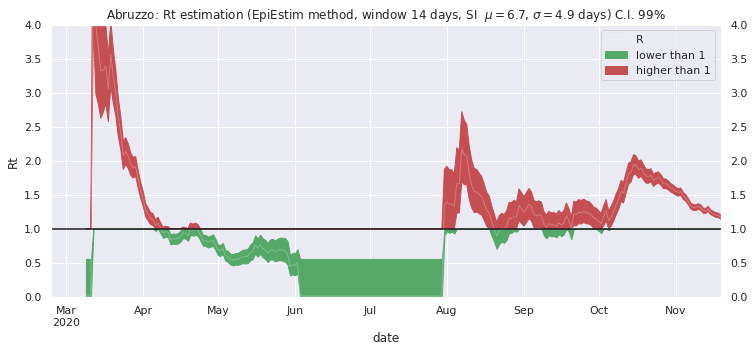

## Basilicata

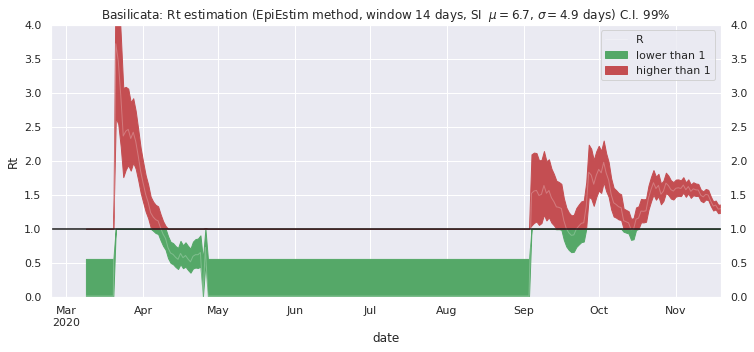

## Calabria

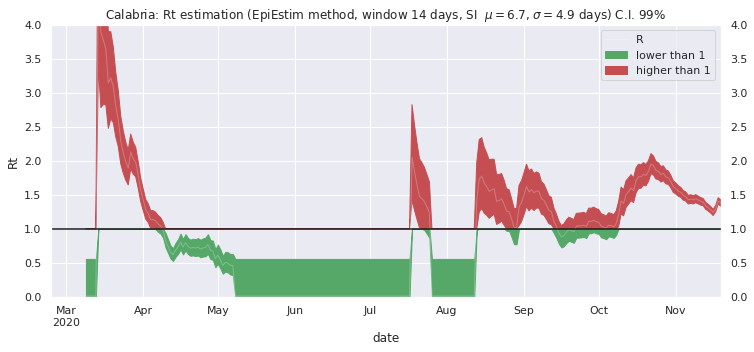

## Campania

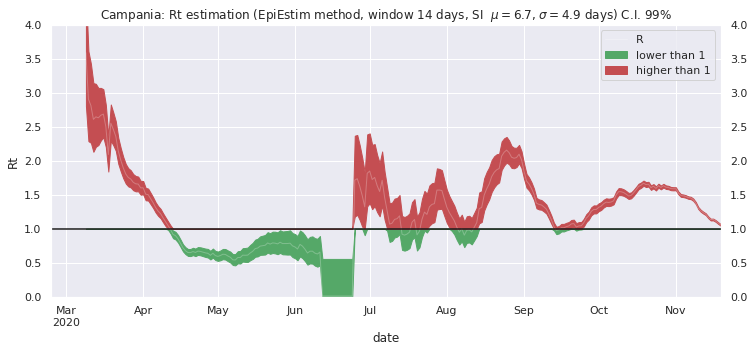

## Emilia-Romagna

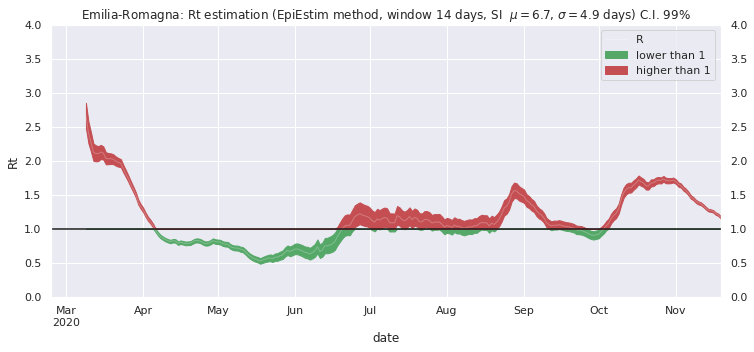

## Friuli Venezia Giulia

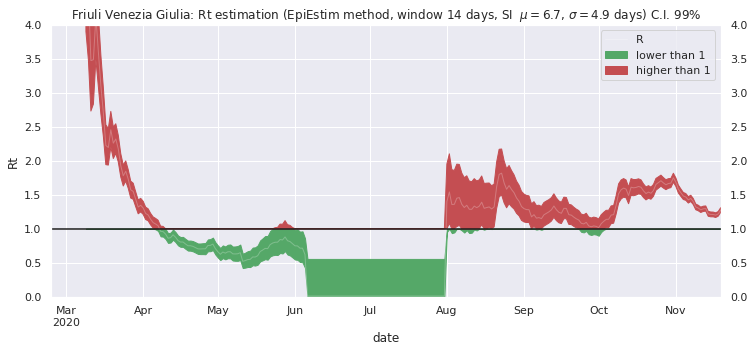

## Lazio

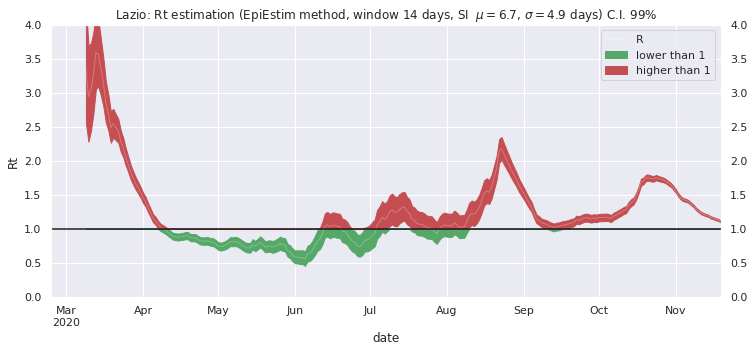

## Liguria

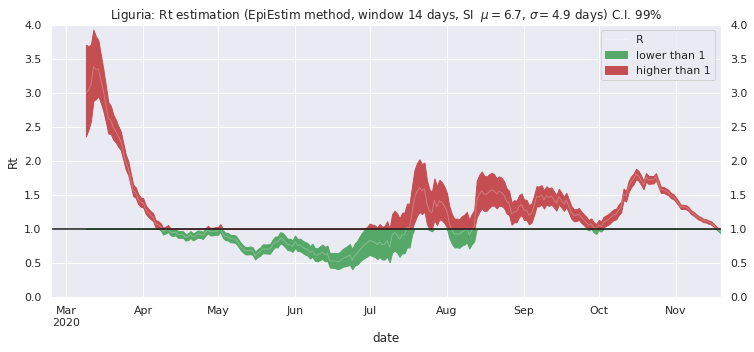

## Lombardia

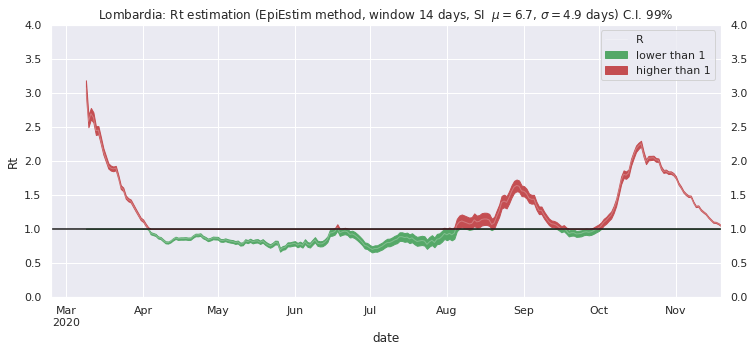

## Marche

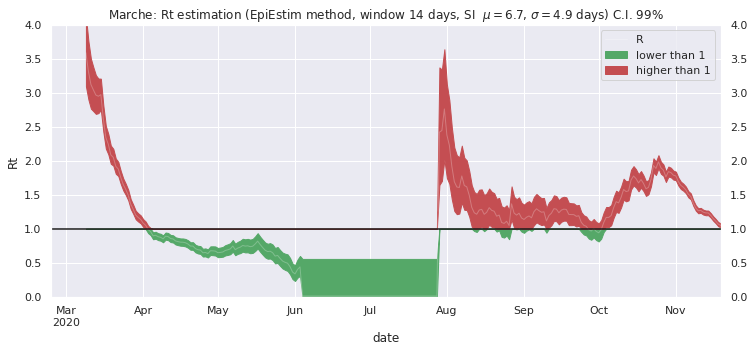

## Molise

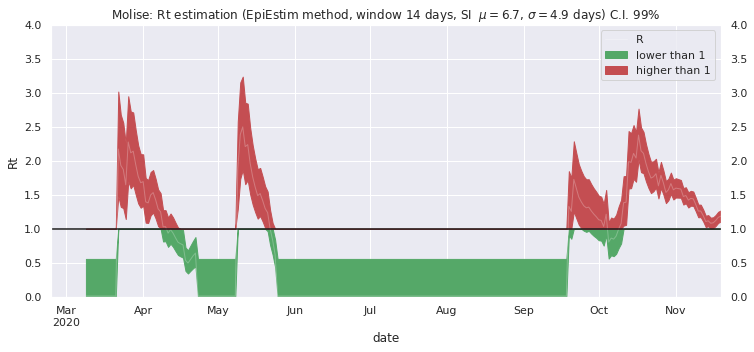

## P.A. Bolzano

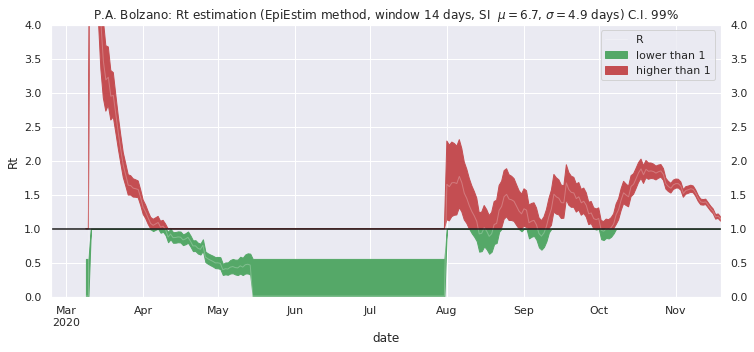

## P.A. Trento

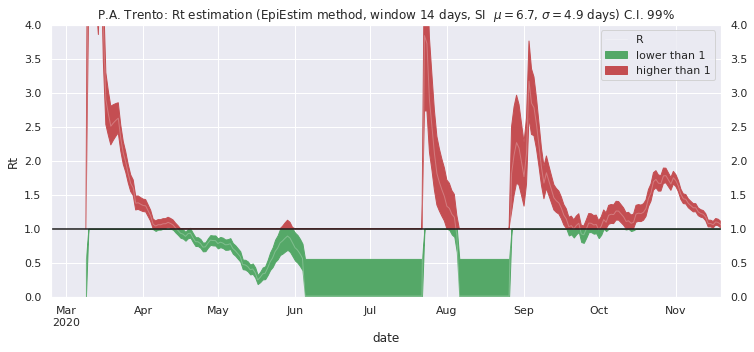

## Piemonte

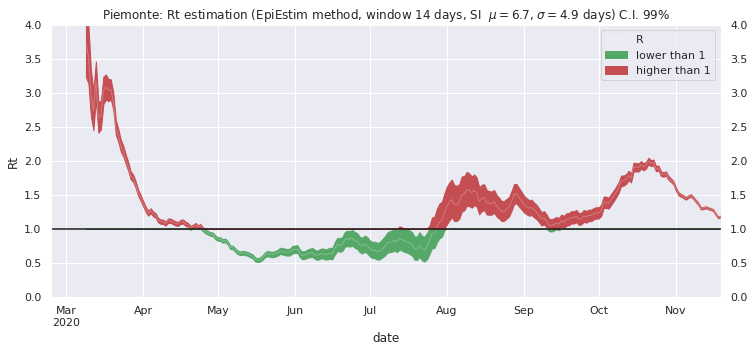

## Puglia

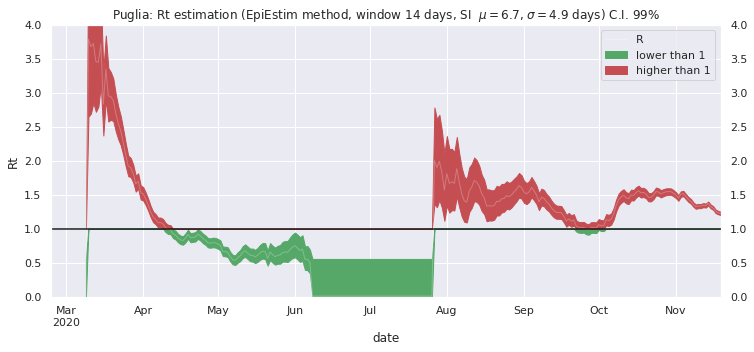

## Sardegna

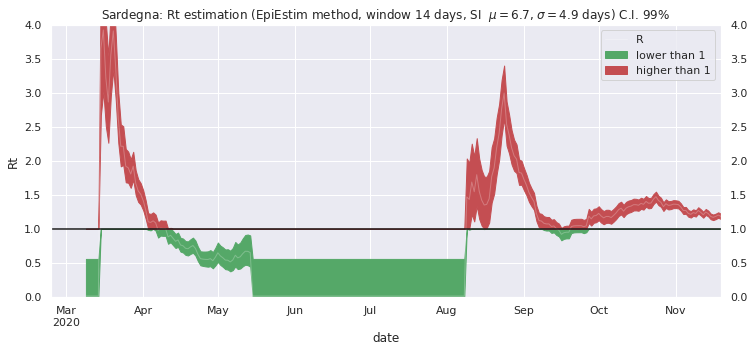

## Sicilia

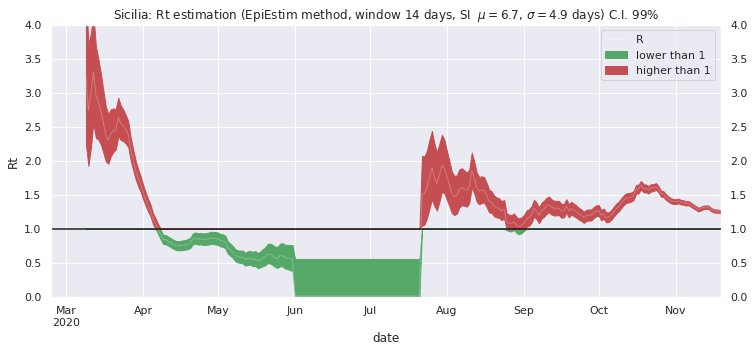

## Toscana

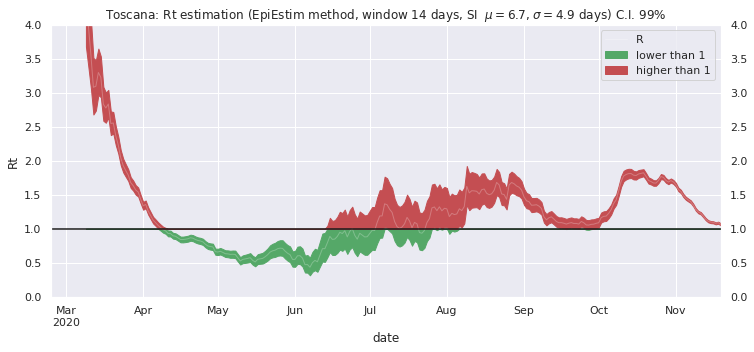

## Umbria

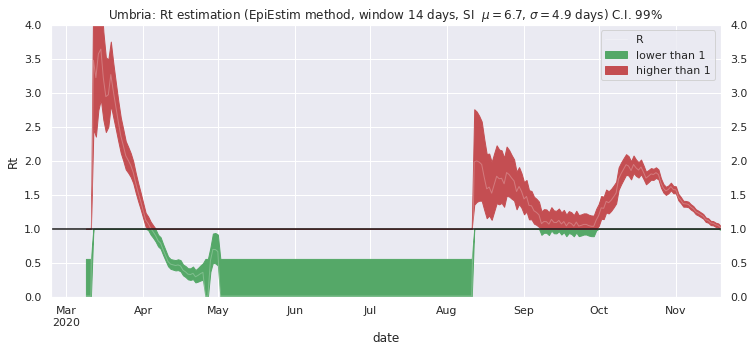

## Valle d'Aosta

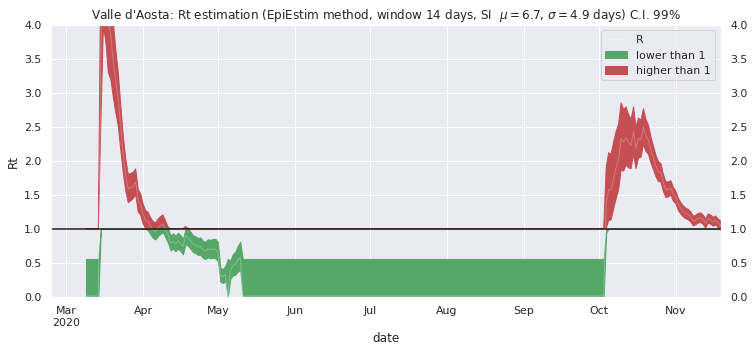

## Veneto

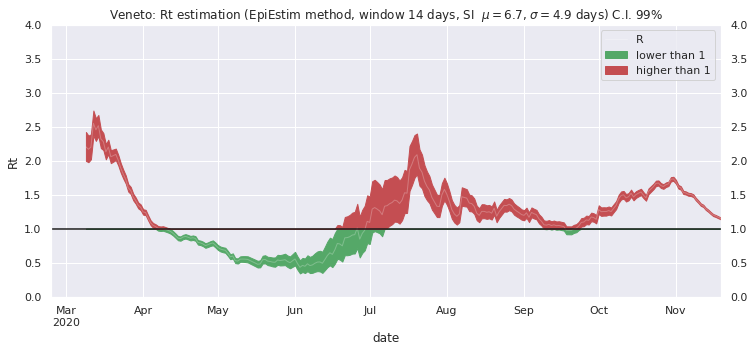

In [20]:
Rt_regioni_json = {}
Rt_latest_regions = {'region': [], 'lo': [], 'mu': [], 'hi': []}

for regione in rg.denominazione_regione.unique():
    
    display(Markdown(f"## {regione}"))

    _df = rg[rg.denominazione_regione==regione]
    T = _df.index.size
    
    original_incidence = _df.nuovi_positivi

    incidence = original_incidence.values
    incidence[incidence<0] = 0
    
    # length of all observations
    T = incidence.size
    SI_tot = np.concatenate((SI_y, np.zeros(T - SI_y.size)))
    final_mean_si = np.sum(
        SI_tot * np.arange(0, SI_tot.size, 1)
    )
    
    Rt, _a, _b = epi_estim_Rt(_df[['nuovi_positivi']], SI_sh=ISS_sh, SI_ra=ISS_ra, title=regione)

    _ = """
    # start and end of posteriors
    t_start = np.arange(1, T - window, 1)
    t_end = t_start + window
    
    model_data = {
        'T': T,
        'D': t_start.size,
        'incidence': incidence,
        'incidence_rev': incidence[::-1],
        't_start': t_start,
        't_end': t_end,
        'SI_pmf': SI_tot,
        'final_mean_si': final_mean_si,
        'P': 14,
        'gamma': final_mean_si,
        'ignore_below': 100
    }
    post = epi_estim_mcmc(model_data)
    pyjags_data = az.from_pyjags(post, warmup_iterations=warmup, save_warmup=False)
    
    smry = plot_Rt(pyjags_data,
                _df.index[window+1:],
                SI_mu, SI_sd,
                window,
                title=regione)
    
    plot_predictions(pyjags_data, 
                         SI_mu, 
                         _df.index[-1],
                         original_incidence,
                         region=regione)"""
    
    Rt_latest_regions['region'].append(regione)
    Rt_latest_regions['mu'].append(Rt['R'].iloc[-1])
    Rt_latest_regions['lo'].append(Rt['q_0.50%'].iloc[-1])
    Rt_latest_regions['hi'].append(Rt['q_99.50%'].iloc[-1])
    
    Rt_regioni_json.update({regione: Rt['R'].iloc[-1]})
    
with open('Rt_regioni.json', 'w') as f:
    json.dump(Rt_regioni_json, f)

# SUMMARY

In [21]:
Rt_latest_regions_df = pd.DataFrame(Rt_latest_regions)

In [22]:
Rt_latest_regions_df['greater_than_1'] = Rt_latest_regions_df.mu>1

In [23]:
Rt_melt_reg = Rt_latest_regions_df.melt(id_vars=['region', 'greater_than_1'])

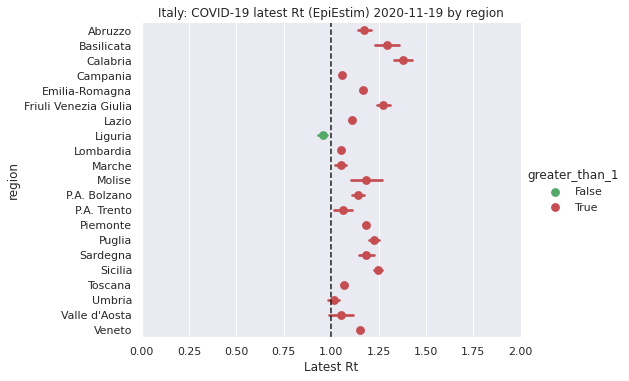

In [24]:
ax = sns.catplot(
    data=Rt_melt_reg,
    kind='point',
    x='value', y='region',
    join=False,
    hue='greater_than_1',
    palette=['C2', 'C3'],
    aspect=1.5,
    ci=100
)

try:
    ax.axes.flat[0].axvline(1, color='k', ls='--')

    ax.axes.flat[0].set(
        xlim=(0, np.ceil(np.max(Rt_latest_regions_df.hi))),
        xlabel='Latest Rt',
        title=f'Italy: COVID-19 latest Rt (EpiEstim) {rg.index[-1].date()} by region'
    )
except Exception as err:
    print(err)

plt.show()

***

In [25]:
end = dt.datetime.now()
print(f"END: {end}")
print(f"Completed in {end - start}")

END: 2020-11-19 17:29:20.245128
Completed in 0:00:37.747714
